In [4]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, count, sum as spark_sum, avg,
    to_date, month, year, concat_ws, lpad, lit,
    desc
)

from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler
)

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import round
from pyspark.sql.functions import year, month, date_format
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import avg, when, col, lit
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import expr
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, DoubleType

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

Spark session initialization

In [5]:
spark = SparkSession.builder \
    .appName("RetailChain_Analytics_Question2") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("Spark session created successfully.")

Spark session created successfully.


Load dataset

In [6]:
file_path = "uk_retail_unbalanced_330k.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

print("Dataset loaded successfully.")
print("Total rows:", df.count())

Dataset loaded successfully.
Total rows: 173601


Schema + sample preview

In [7]:

df.printSchema()

df.show(10, truncate=False)

root
 |-- transaction_id: string (nullable = true)
 |-- transaction_time: timestamp (nullable = true)
 |-- store_id: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- unit_price_gbp: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- vat_rate: double (nullable = true)
 |-- discount_pct: integer (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- postcode_area: string (nullable = true)
 |-- return_flag: string (nullable = true)
 |-- total_amount_gbp: double (nullable = true)

+------------------------------------+--------------------------+------------+--------+-----------+----------------+----------+----------------+--------------+--------+--------+------------+--------------+-----------+-------------+---------

Null/missing values summary

In [8]:


missing_df = df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

missing_df.show(truncate=False)

+--------------+----------------+--------+-------+-----------+----------------+----------+----------------+--------------+--------+--------+------------+--------------+-----------+-------------+-----------+----------------+
|transaction_id|transaction_time|store_id|channel|customer_id|customer_segment|product_id|product_category|unit_price_gbp|quantity|vat_rate|discount_pct|payment_method|device_type|postcode_area|return_flag|total_amount_gbp|
+--------------+----------------+--------+-------+-----------+----------------+----------+----------------+--------------+--------+--------+------------+--------------+-----------+-------------+-----------+----------------+
|0             |0               |0       |0      |0          |0               |0         |0               |0             |0       |0       |0           |0             |0          |0            |0          |0               |
+--------------+----------------+--------+-------+-----------+----------------+----------+--------------

Cleaning dataset

In [9]:


df_clean = df.withColumn("transaction_time", to_timestamp(col("transaction_time")))

df_clean = df_clean.filter(
    col("transaction_time").isNotNull() &
    col("unit_price_gbp").isNotNull() &
    col("quantity").isNotNull() &
    col("total_amount_gbp").isNotNull()
)

df_clean = df_clean.filter(
    (col("unit_price_gbp") > 0) &
    (col("quantity") > 0) &
    (col("total_amount_gbp") > 0)
)

print("Cleaned dataset rows:", df_clean.count())
df_clean.show(5, truncate=False)

Cleaned dataset rows: 173601
+------------------------------------+--------------------------+------------+--------+-----------+----------------+----------+----------------+--------------+--------+--------+------------+--------------+-----------+-------------+-----------+----------------+
|transaction_id                      |transaction_time          |store_id    |channel |customer_id|customer_segment|product_id|product_category|unit_price_gbp|quantity|vat_rate|discount_pct|payment_method|device_type|postcode_area|return_flag|total_amount_gbp|
+------------------------------------+--------------------------+------------+--------+-----------+----------------+----------+----------------+--------------+--------+--------+------------+--------------+-----------+-------------+-----------+----------------+
|52b8c72f-1a8b-4afa-9c07-c09ba3d980f5|2025-10-16 12:26:14.456693|UK_STORE_68 |In-Store|CUST_156670|Regular         |SKU_653949|Fashion         |186.12        |4       |0.05    |30         

Validate Total Amount Calculation

In [10]:


df_clean = df_clean.withColumn(
    "calculated_amount",
    round(col("unit_price_gbp") * col("quantity"), 2)
)

df_clean = df_clean.withColumn(
    "revenue_gap",
    round(col("total_amount_gbp") - col("calculated_amount"), 2)
)

df_clean.select(
    "transaction_id", "unit_price_gbp", "quantity",
    "total_amount_gbp", "calculated_amount", "revenue_gap"
).show(10, truncate=False)

+------------------------------------+--------------+--------+----------------+-----------------+-----------+
|transaction_id                      |unit_price_gbp|quantity|total_amount_gbp|calculated_amount|revenue_gap|
+------------------------------------+--------------+--------+----------------+-----------------+-----------+
|52b8c72f-1a8b-4afa-9c07-c09ba3d980f5|186.12        |4       |547.19          |744.48           |-197.29    |
|f6b0a488-6645-43f8-b635-02f1e88395bc|64.67         |5       |388.02          |323.35           |64.67      |
|8bbc02af-428f-48bb-982b-b5cc643d1ce1|2.69          |4       |12.27           |10.76            |1.51       |
|25fe02aa-66f8-45c0-954f-47c23df509c5|17.03         |2       |38.83           |34.06            |4.77       |
|6e651a98-bdf1-4047-a325-364bd17680b8|473.37        |1       |511.24          |473.37           |37.87      |
|c3622d58-58c7-4db1-9648-74bb32e9c2c5|13.99         |4       |67.15           |55.96            |11.19      |
|310eb1ec-

Feature Engineering: Year, Month, Year-Month

In [11]:


df_clean = df_clean.withColumn("year", year(col("transaction_time")))
df_clean = df_clean.withColumn("month", month(col("transaction_time")))
df_clean = df_clean.withColumn("year_month", date_format(col("transaction_time"), "yyyy-MM"))

df_clean.select("transaction_time", "year", "month", "year_month").show(10, truncate=False)

+--------------------------+----+-----+----------+
|transaction_time          |year|month|year_month|
+--------------------------+----+-----+----------+
|2025-10-16 12:26:14.456693|2025|10   |2025-10   |
|2025-11-26 05:50:20.456693|2025|11   |2025-11   |
|2026-01-23 09:07:25.456693|2026|1    |2026-01   |
|2026-01-10 03:21:44.456693|2026|1    |2026-01   |
|2025-11-24 19:39:47.456693|2025|11   |2025-11   |
|2025-11-14 14:32:56.456693|2025|11   |2025-11   |
|2025-12-01 16:23:02.456693|2025|12   |2025-12   |
|2025-11-27 18:45:31.456693|2025|11   |2025-11   |
|2025-10-28 20:03:09.456693|2025|10   |2025-10   |
|2025-12-04 05:40:32.456693|2025|12   |2025-12   |
+--------------------------+----+-----+----------+
only showing top 10 rows


Yearly Revenue Trend

In [12]:


yearly_revenue = df_clean.groupBy("year") \
    .agg(spark_sum("total_amount_gbp").alias("yearly_total_revenue")) \
    .orderBy("year")

yearly_revenue.show(truncate=False)

+----+--------------------+
|year|yearly_total_revenue|
+----+--------------------+
|2025|2.5477515900000148E7|
|2026|1.1526489770000003E7|
+----+--------------------+



Plot Yearly Revenue Trend

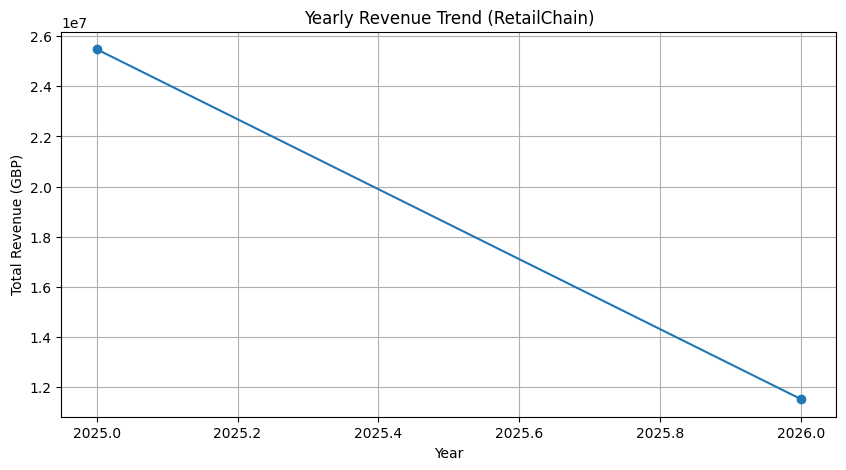

In [13]:


yearly_pd = yearly_revenue.toPandas()

plt.figure(figsize=(10,5))
plt.plot(yearly_pd["year"], yearly_pd["yearly_total_revenue"], marker="o")
plt.title("Yearly Revenue Trend (RetailChain)")
plt.xlabel("Year")
plt.ylabel("Total Revenue (GBP)")
plt.grid(True)
plt.show()

Monthly Revenue Trend

In [14]:
monthly_revenue = df_clean.groupBy("year_month") \
    .agg(spark_sum("total_amount_gbp").alias("monthly_total_revenue")) \
    .orderBy("year_month")

monthly_revenue.show(20, truncate=False)


+----------+---------------------+
|year_month|monthly_total_revenue|
+----------+---------------------+
|2025-10   |5988349.349999977    |
|2025-11   |9543876.469999967    |
|2025-12   |9945290.079999965    |
|2026-01   |9979717.710000008    |
|2026-02   |1546772.0599999977   |
+----------+---------------------+



Plot Monthly Revenue Trend

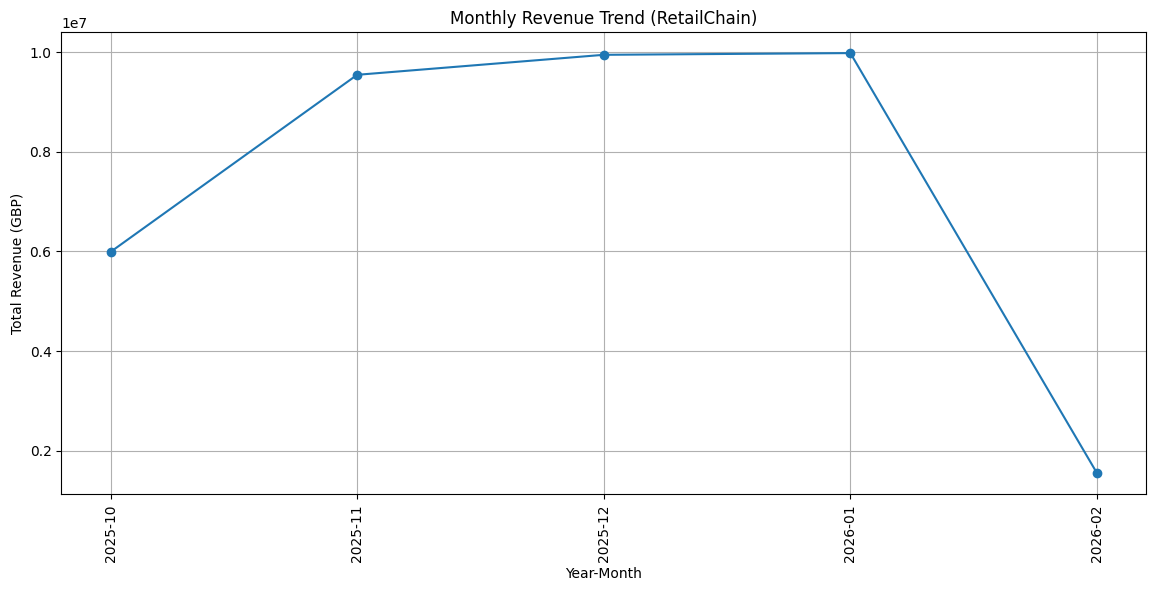

In [15]:
monthly_pd = monthly_revenue.toPandas()

plt.figure(figsize=(14,6))
plt.plot(monthly_pd["year_month"], monthly_pd["monthly_total_revenue"], marker="o")
plt.title("Monthly Revenue Trend (RetailChain)")
plt.xlabel("Year-Month")
plt.ylabel("Total Revenue (GBP)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Top Product Categories by Revenue

In [16]:
category_revenue = df_clean.groupBy("product_category") \
    .agg(spark_sum("total_amount_gbp").alias("category_total_revenue")) \
    .orderBy(col("category_total_revenue").desc())

category_revenue.show(10, truncate=False)

+----------------+----------------------+
|product_category|category_total_revenue|
+----------------+----------------------+
|Electronics     |1.5811269470000023E7  |
|Home            |1.0748175380000006E7  |
|Fashion         |5778676.76999998      |
|Grocery         |2848523.16000001      |
|Beauty          |1817360.8900000025    |
+----------------+----------------------+



Plot Category Revenue

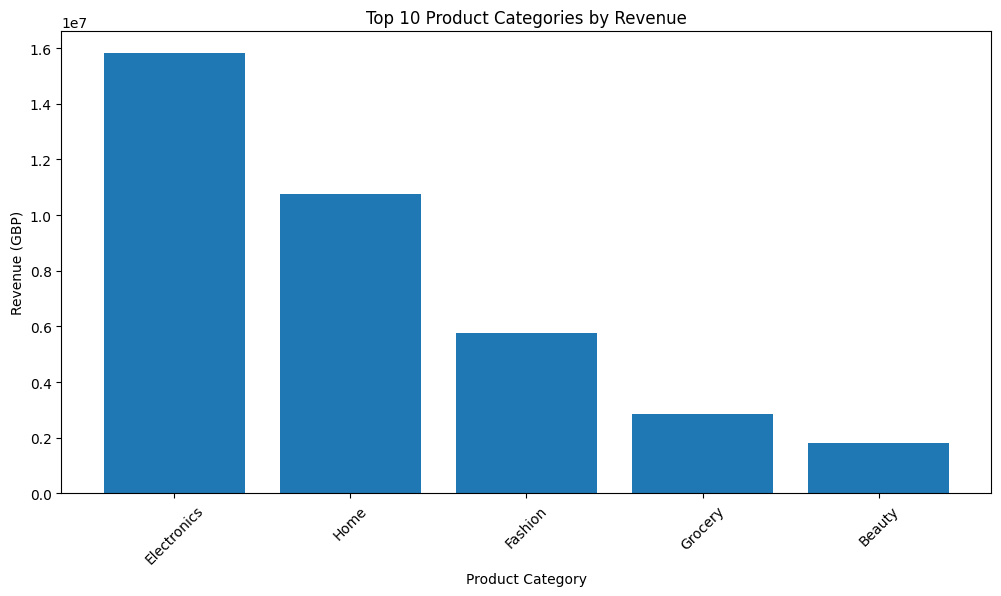

In [17]:
category_pd = category_revenue.limit(10).toPandas()

plt.figure(figsize=(12,6))
plt.bar(category_pd["product_category"], category_pd["category_total_revenue"])
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Product Category")
plt.ylabel("Revenue (GBP)")
plt.xticks(rotation=45)
plt.show()

Return Rate by Product Category

In [18]:


return_rate_category = df_clean.groupBy("product_category") \
    .agg(avg(when(col("return_flag") == "Yes", 1).otherwise(0)).alias("return_rate")) \
    .orderBy(col("return_rate").desc())

return_rate_category.show(10, truncate=False)

+----------------+--------------------+
|product_category|return_rate         |
+----------------+--------------------+
|Beauty          |0.03656998738965952 |
|Grocery         |0.035582125816222956|
|Home            |0.035397503285151115|
|Fashion         |0.03534253207455822 |
|Electronics     |0.03449769053117783 |
+----------------+--------------------+



Plot Return Rate

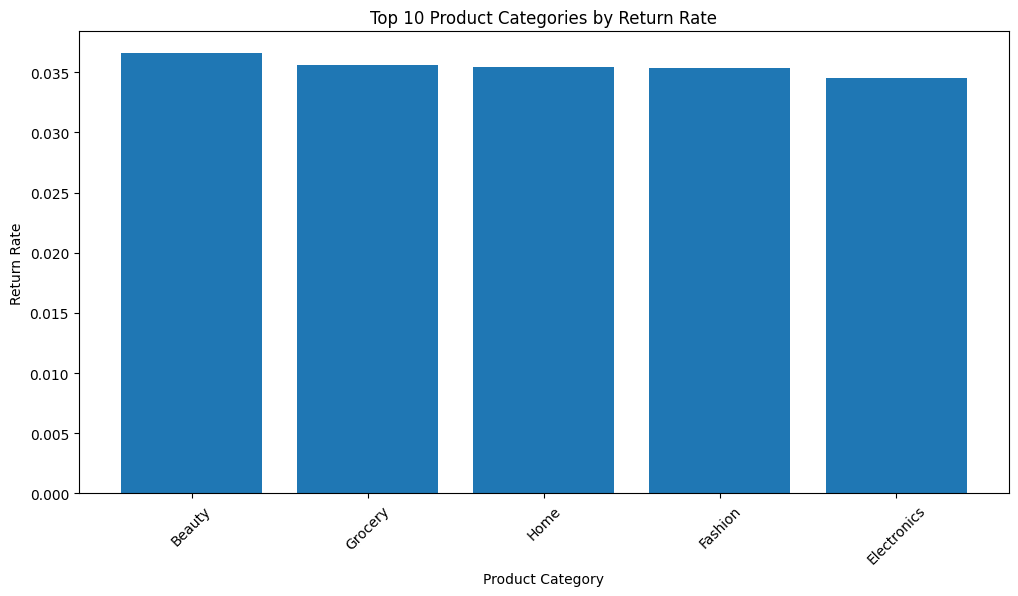

In [19]:
return_pd = return_rate_category.limit(10).toPandas()

plt.figure(figsize=(12,6))
plt.bar(return_pd["product_category"], return_pd["return_rate"])
plt.title("Top 10 Product Categories by Return Rate")
plt.xlabel("Product Category")
plt.ylabel("Return Rate")
plt.xticks(rotation=45)
plt.show()

Fraud Detection

In [20]:


df_clean = df_clean.withColumn(
    "fraud_risk_score",
    (
        when(col("total_amount_gbp") > 500, 2).otherwise(0) +
        when(col("quantity") > 30, 2).otherwise(0) +
        when(col("discount_pct") > 50, 2).otherwise(0) +
        when(col("return_flag") == "Yes", 1).otherwise(0)
    )
)

df_clean = df_clean.withColumn(
    "fraud_flag",
    when(col("fraud_risk_score") >= 5, 1).otherwise(0)
)

df_clean.select(
    "transaction_id", "customer_id", "product_category",
    "quantity", "discount_pct", "total_amount_gbp",
    "return_flag", "fraud_risk_score", "fraud_flag"
).show(20, truncate=False)

+------------------------------------+-----------+----------------+--------+------------+----------------+-----------+----------------+----------+
|transaction_id                      |customer_id|product_category|quantity|discount_pct|total_amount_gbp|return_flag|fraud_risk_score|fraud_flag|
+------------------------------------+-----------+----------------+--------+------------+----------------+-----------+----------------+----------+
|52b8c72f-1a8b-4afa-9c07-c09ba3d980f5|CUST_156670|Fashion         |4       |30          |547.19          |No         |2               |0         |
|f6b0a488-6645-43f8-b635-02f1e88395bc|CUST_36015 |Fashion         |5       |0           |388.02          |No         |0               |0         |
|8bbc02af-428f-48bb-982b-b5cc643d1ce1|CUST_133239|Grocery         |4       |5           |12.27           |No         |0               |0         |
|25fe02aa-66f8-45c0-954f-47c23df509c5|CUST_60586 |Grocery         |2       |5           |38.83           |No         |

Fraud Rate Trend by Month

In [21]:
fraud_monthly = df_clean.groupBy("year_month") \
    .agg(
        spark_sum("fraud_flag").alias("fraud_transactions"),
        spark_sum(when(col("fraud_flag") == 0, 1).otherwise(0)).alias("normal_transactions")
    )

fraud_monthly = fraud_monthly.withColumn(
    "total_transactions",
    col("fraud_transactions") + col("normal_transactions")
)

fraud_monthly = fraud_monthly.withColumn(
    "fraud_rate",
    round(col("fraud_transactions") / col("total_transactions"), 4)
).orderBy("year_month")

fraud_monthly.show(20, truncate=False)

+----------+------------------+-------------------+------------------+----------+
|year_month|fraud_transactions|normal_transactions|total_transactions|fraud_rate|
+----------+------------------+-------------------+------------------+----------+
|2025-10   |0                 |27753              |27753             |0.0       |
|2025-11   |0                 |45033              |45033             |0.0       |
|2025-12   |0                 |46816              |46816             |0.0       |
|2026-01   |0                 |46428              |46428             |0.0       |
|2026-02   |0                 |7571               |7571              |0.0       |
+----------+------------------+-------------------+------------------+----------+



Plot Fraud Trend

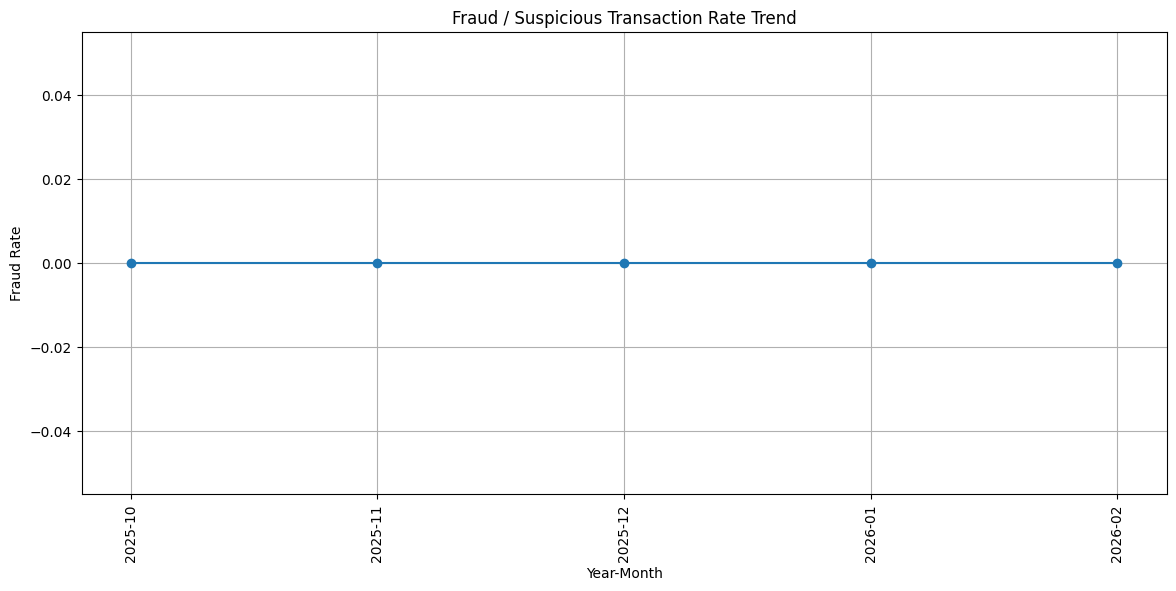

In [22]:
fraud_pd = fraud_monthly.toPandas()

plt.figure(figsize=(14,6))
plt.plot(fraud_pd["year_month"], fraud_pd["fraud_rate"], marker="o")
plt.title("Fraud / Suspicious Transaction Rate Trend")
plt.xlabel("Year-Month")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Customer Spending & High Spender Label

In [23]:
customer_spend = df_clean.groupBy("customer_id") \
    .agg(spark_sum("total_amount_gbp").alias("customer_total_spend"))

customer_spend.show(10, truncate=False)

# Calculate 80th percentile threshold
threshold = customer_spend.approxQuantile("customer_total_spend", [0.8], 0.01)[0]
print("High spender threshold (80th percentile):", threshold)

customer_spend = customer_spend.withColumn(
    "high_spender",
    when(col("customer_total_spend") >= threshold, 1).otherwise(0)
)

customer_spend.groupBy("high_spender").count().show()

+-----------+--------------------+
|customer_id|customer_total_spend|
+-----------+--------------------+
|CUST_117442|310.85              |
|CUST_16401 |179.42              |
|CUST_55937 |22.4                |
|CUST_81350 |22.84               |
|CUST_83049 |154.88000000000002  |
|CUST_125227|312.54              |
|CUST_98420 |12.42               |
|CUST_50858 |58.309999999999995  |
|CUST_2888  |1079.47             |
|CUST_55149 |118.21              |
+-----------+--------------------+
only showing top 10 rows
High spender threshold (80th percentile): 310.63
+------------+-----+
|high_spender|count|
+------------+-----+
|           1|23234|
|           0|87846|
+------------+-----+



Merge High Spender Label Back to Transactions

In [24]:
df_clean = df_clean.join(customer_spend.select("customer_id", "high_spender"), on="customer_id", how="left")

df_clean.select("customer_id", "total_amount_gbp", "high_spender").show(10, truncate=False)


+-----------+----------------+------------+
|customer_id|total_amount_gbp|high_spender|
+-----------+----------------+------------+
|CUST_156670|547.19          |1           |
|CUST_36015 |388.02          |1           |
|CUST_133239|12.27           |1           |
|CUST_60586 |38.83           |0           |
|CUST_112494|511.24          |1           |
|CUST_15056 |67.15           |0           |
|CUST_152084|156.6           |0           |
|CUST_65879 |1240.3          |1           |
|CUST_76486 |212.19          |1           |
|CUST_91106 |10.88           |0           |
+-----------+----------------+------------+
only showing top 10 rows


Prepare ML Dataset

In [25]:
ml_df = df_clean.select(
    "unit_price_gbp",
    "quantity",
    "discount_pct",
    "vat_rate",
    "total_amount_gbp",
    "year",
    "month",
    "channel",
    "customer_segment",
    "product_category",
    "payment_method",
    "device_type",
    "postcode_area",
    "return_flag",
    "high_spender"
).dropna()

print("ML dataset rows:", ml_df.count())
ml_df.show(5, truncate=False)


ML dataset rows: 173601
+--------------+--------+------------+--------+----------------+----+-----+--------+----------------+----------------+--------------+-----------+-------------+-----------+------------+
|unit_price_gbp|quantity|discount_pct|vat_rate|total_amount_gbp|year|month|channel |customer_segment|product_category|payment_method|device_type|postcode_area|return_flag|high_spender|
+--------------+--------+------------+--------+----------------+----+-----+--------+----------------+----------------+--------------+-----------+-------------+-----------+------------+
|186.12        |4       |30          |0.05    |547.19          |2025|10   |In-Store|Regular         |Fashion         |Cash          |POS        |SW           |No         |1           |
|64.67         |5       |0           |0.2     |388.02          |2025|11   |In-Store|Regular         |Fashion         |Debit Card    |POS        |E            |No         |1           |
|2.69          |4       |5           |0.2     |12.2

Spark MLlib Pipeline

In [26]:


categorical_cols = ["channel", "customer_segment", "product_category", "payment_method", "device_type", "postcode_area"]
numeric_cols = ["unit_price_gbp", "quantity", "discount_pct", "vat_rate", "total_amount_gbp", "year", "month"]

# StringIndexer for categorical features
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") for c in categorical_cols]
# OneHotEncoder for indexed categorical features
encoders = [OneHotEncoder(inputCol=c+"_idx", outputCol=c+"_ohe") for c in categorical_cols]

# StringIndexer for the label column 'return_flag'
label_indexer = StringIndexer(inputCol="return_flag", outputCol="label")

assembler_inputs = [c+"_ohe" for c in categorical_cols] + numeric_cols

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

lr_return = LogisticRegression(featuresCol="features", labelCol="label") # Use the indexed label column

pipeline_return = Pipeline(stages=indexers + encoders + [label_indexer, assembler, lr_return])

train_return, test_return = ml_df.randomSplit([0.7, 0.3], seed=42)

model_return = pipeline_return.fit(train_return)
pred_return = model_return.transform(test_return)

pred_return.select("return_flag", "probability", "prediction").show(10, truncate=False)

+-----------+-----------------------------------------+----------+
|return_flag|probability                              |prediction|
+-----------+-----------------------------------------+----------+
|No         |[0.9703964794000176,0.02960352059998239] |0.0       |
|No         |[0.9643497870541845,0.035650212945815496]|0.0       |
|No         |[0.968622919383716,0.03137708061628397]  |0.0       |
|No         |[0.9640288247648199,0.03597117523518012] |0.0       |
|No         |[0.963612001739856,0.03638799826014405]  |0.0       |
|No         |[0.9641558105091407,0.035844189490859324]|0.0       |
|No         |[0.9650166822825014,0.03498331771749863] |0.0       |
|No         |[0.9610652876822702,0.038934712317729825]|0.0       |
|No         |[0.9696409148418573,0.030359085158142673]|0.0       |
|No         |[0.9664388744718116,0.03356112552818835] |0.0       |
+-----------+-----------------------------------------+----------+
only showing top 10 rows


Return Model Evaluation (AUC + Confusion Matrix)

In [27]:


evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

auc_return = evaluator.evaluate(pred_return)
print("Return Prediction Model AUC:", auc_return)

# Confusion Matrix
conf_matrix_return = pred_return.groupBy("return_flag", "prediction").count().orderBy("return_flag", "prediction")
conf_matrix_return.show()

# Accuracy
accuracy_return = pred_return.filter(col("label") == col("prediction")).count() / pred_return.count()
print("Return Prediction Model Accuracy:", accuracy_return)


Return Prediction Model AUC: 0.5086089445950116
+-----------+----------+-----+
|return_flag|prediction|count|
+-----------+----------+-----+
|         No|       0.0|50232|
|        Yes|       0.0| 1838|
+-----------+----------+-----+

Return Prediction Model Accuracy: 0.9647013635490685


Spark MLlib Pipeline (High Spender Prediction)

In [28]:
lr_spender = LogisticRegression(featuresCol="features", labelCol="high_spender")

pipeline_spender = Pipeline(stages=indexers + encoders + [assembler, lr_spender])

train_spender, test_spender = ml_df.randomSplit([0.7, 0.3], seed=42)

model_spender = pipeline_spender.fit(train_spender)
pred_spender = model_spender.transform(test_spender)

pred_spender.select("high_spender", "probability", "prediction").show(10, truncate=False)


+------------+----------------------------------------+----------+
|high_spender|probability                             |prediction|
+------------+----------------------------------------+----------+
|0           |[0.885870006213119,0.11412999378688105] |0.0       |
|0           |[0.8822611467716234,0.11773885322837663]|0.0       |
|0           |[0.8759398197935674,0.12406018020643261]|0.0       |
|0           |[0.8867036094661451,0.11329639053385487]|0.0       |
|0           |[0.8865111536108656,0.11348884638913437]|0.0       |
|0           |[0.8994924745061811,0.10050752549381892]|0.0       |
|0           |[0.890710341277155,0.10928965872284502] |0.0       |
|0           |[0.9292374425737844,0.07076255742621562]|0.0       |
|0           |[0.8740085899982607,0.1259914100017393] |0.0       |
|0           |[0.8756976021199357,0.12430239788006425]|0.0       |
+------------+----------------------------------------+----------+
only showing top 10 rows


High Spender Model Evaluation (AUC + Confusion Matrix)

In [29]:
evaluator2 = BinaryClassificationEvaluator(labelCol="high_spender", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

auc_spender = evaluator2.evaluate(pred_spender)
print("High Spender Model AUC:", auc_spender)

conf_matrix_spender = pred_spender.groupBy("high_spender", "prediction").count().orderBy("high_spender", "prediction")
conf_matrix_spender.show()

accuracy_spender = pred_spender.filter(col("high_spender") == col("prediction")).count() / pred_spender.count()
print("High Spender Model Accuracy:", accuracy_spender)


High Spender Model AUC: 0.7790715876806377
+------------+----------+-----+
|high_spender|prediction|count|
+------------+----------+-----+
|           0|       0.0|37964|
|           0|       1.0|  499|
|           1|       0.0| 6266|
|           1|       1.0| 7341|
+------------+----------+-----+

High Spender Model Accuracy: 0.8700787401574803


Export Evidence Outputs

In [30]:


output_dir = "RetailChain_outputs"

yearly_revenue.coalesce(1).write.mode("overwrite").option("header", True).csv(output_dir + "/yearly_revenue")
monthly_revenue.coalesce(1).write.mode("overwrite").option("header", True).csv(output_dir + "/monthly_revenue")
category_revenue.coalesce(1).write.mode("overwrite").option("header", True).csv(output_dir + "/category_revenue")
return_rate_category.coalesce(1).write.mode("overwrite").option("header", True).csv(output_dir + "/return_rate_category")
fraud_monthly.coalesce(1).write.mode("overwrite").option("header", True).csv(output_dir + "/fraud_monthly")

# Define a UDF to convert the VectorUDT to a standard Python list
def extract_vector_elements(vector_col):
    if vector_col is not None:
        # Assuming DenseVector for probabilities, convert to array and then list
        return vector_col.toArray().tolist()
    return [None, None] # Default for null or other cases, adjust as needed

# Register the UDF with the correct return type
extract_vector_udf = udf(extract_vector_elements, ArrayType(DoubleType()))

# Apply the UDF to create a new column 'prob_array' which is a standard ArrayType
pred_return_processed = pred_return.withColumn("prob_array", extract_vector_udf(col("probability")))
pred_spender_processed = pred_spender.withColumn("prob_array", extract_vector_udf(col("probability")))

# Now select from the new DataFrame with the 'prob_array' column
pred_return_processed.select("return_flag", col("prob_array")[0].alias("prob_no_return"), col("prob_array")[1].alias("prob_yes_return"), "prediction") \
    .coalesce(1).write.mode("overwrite").option("header", True).csv(output_dir + "/return_predictions")
pred_spender_processed.select("high_spender", col("prob_array")[0].alias("prob_low_spender"), col("prob_array")[1].alias("prob_high_spender"), "prediction") \
    .coalesce(1).write.mode("overwrite").option("header", True).csv(output_dir + "/spender_predictions")

print(" All outputs exported successfully into:", output_dir)

 All outputs exported successfully into: RetailChain_outputs


Stop Spark

In [31]:
spark.stop()
print(" Spark session stopped successfully.")


 Spark session stopped successfully.
